# Predicting hospital readmission within 30 days of discharge for diabetic patients

In this project I aim to predict which diabetic patients will be readmitted within 30 days of discharge and to determine the factors that lead to hospital readmissions. Medicare has a policy to penalize hospitals with excessive readmission rates, making it a priority for hospitals to prevent readmissions also from a financial standpoint. Building this model benefits both patients and hospitals. By identifying specific patients more likely to be readmitted, and more broadly, which factors lead to readmission within 30 days of discharge, the hospitals could implement a variety of strategies to educate patients, provide them with resources, and appropriate outpatient follow-up with a primary care provider. Patients benefit from improved health outcomes and avoiding preventable hospital stays. The target of this project is UPMC hospitals. The best supervised machine learning model generated in this project was a **random forests model**. 

The dataset analyzed is "Diabetes 130-Hospitals for years 1999-2008", and can be found here: https://archive-beta.ics.uci.edu/ml/datasets/diabetes+130+us+hospitals+for+years+1999+2008

This is a 7 min video that I recorded in which I explain the gist of this project: https://www.youtube.com/watch?v=tw0uWofQOTg

**Classification metrics of interest**: In this project, both precision and recall are relevant. For this reason, I chose the F1 score as the classification metric to be optimized.

In [175]:
# This loads the libraries that will be used:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import imblearn.over_sampling

from sklearn.model_selection import PredefinedSplit # To deal with data bleeding
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# This configures jupyter for rendering plots 
%pylab inline
%config InlineBackend.figure_formats = ['retina']


Populating the interactive namespace from numpy and matplotlib


This loads the dataset:

In [82]:
diabetic_data = pd.read_csv('diabetic_data.csv')

In [83]:
diabetic_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


This replaces '?' with 'NaN':

In [84]:
diabetic_data.replace('?', np.NaN,inplace=True) 

## Binarize the target feature:

The target feature ('readmitted') has three classes: 
- '<30' : a readmission happened in fewer than 30 days after discharge.
- '>30' : a readmission happened in more than 30 days after discharge.
- 'NO': there is no record of a subsequent readmission.

In this project, I chose to binarize the the target feature with the aim of making a less complex model. The two resulting classes are:
- '1': the positive class. A readmission happened < 30 days after discharge.
- '0': the negative class. Either there was no record of readmission or this happened in more than 30 days of discharge.


The code below defines a helper function, **'makes_target_binary'**, which is immediately applied to the target feature, generating a new columnm **'readmitted_binary_target'** that will be the target feature used throughout this project:

In [85]:
def makes_target_binary(row):
    if row == '<30':
        return 1
    else:
        return 0
    
diabetic_data['readmitted_binary_target'] =  diabetic_data['readmitted'].apply(makes_target_binary)   

## Check for class imbalance:
The code below checks if there is class imbalance in the target feature (**'readmitted_binary_target'**):

0    0.888401
1    0.111599
Name: readmitted_binary_target, dtype: float64


<AxesSubplot:>

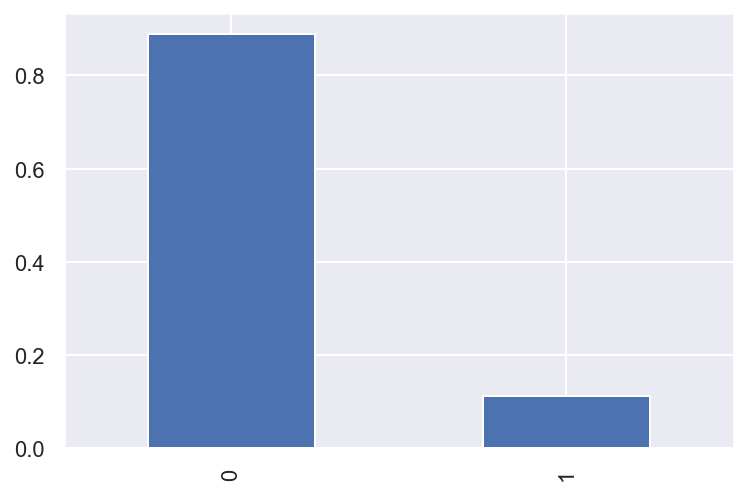

In [86]:
target_values = diabetic_data.readmitted_binary_target.value_counts(normalize=True) 
print(target_values)
target_values.plot(kind='bar')

*There is class imbalance*, which I will handle downstream in the analysis pipeline.

## Check if some patients were admitted to the hospital more than once:

Or in other words, if some patients appear on more than one row:

In [87]:
# Unique patients
number_unique_patients = diabetic_data['patient_nbr'].nunique() # Finds the number of unique patients. 
total_admissions = len(diabetic_data) # stores the total number of rows (each row = one admission into the hospital). 

print(f'number of unique patients: {number_unique_patients}')
print(f'total number of admissions: {total_admissions}')

number of unique patients: 71518
total number of admissions: 101766


Given that *'number of unique patients'* < *'total number of admissions'*, this means that some patients appear in more than one row. 
This is relevant because, **if not handled appropiately, it could cause data bleeding** and **overfitting**: data from the same patient might be **both** in the training set and in the validation/test sets. This should be avoided.

For the baseline model, I will use a single training/validation split scheme.

These are functions that I will use:

In [ ]:
def prepares_dataset_for_current_model(df,features_model):
    
    '''
    
    '''
    
    final_features = ['patient_nbr','readmitted_binary_target']
    final_features.extend(features_model)
    df_model = df[final_features].copy()
    df_model.columns = final_features
    return df_model

## Categorical variables - generate dummy variables

In [88]:
diabetic_data_with_dummies = diabetic_data.copy()

In [89]:
def relabels_classes(row,classes_percentage):
    '''
    Helper function. If the observation belongs to a class with fewer than 5.0% of the total number of observations (rows),
    it re-labels the class as 'Other'. 
    '''
    if classes_percentage[row] < 5.0:
        return 'Other'
    else: 
        return row

In [90]:
list_categorical_columns = []
for column in diabetic_data_with_dummies.columns:
    if dtype(diabetic_data_with_dummies[column]) == 'object' and column !='readmitted' and column !='readmitted_binary_target': # If the column is categorical but not the target column. 
        list_categorical_columns.append(column) # Stores the column name in list_categorical_columns, to generate dummy variables in the next cell.
        diabetic_data_with_dummies[column].fillna('null_value',inplace=True) # all null values are labelled with a new class 'null_value'. This way, not collecting information becomes a class in itself.
        classes_count = diabetic_data_with_dummies[column].value_counts() # 'classes_count' is a series with the counts for each unique class.
        classes_percentage = classes_count/classes_count.sum()*100 # 'classes_percentage' is a series with the percentages of total observations for each unique class.
        diabetic_data_with_dummies[column] = diabetic_data_with_dummies[column].apply(relabels_classes,classes_percentage = classes_percentage)  

In [91]:
# All the categorical features (but not the target, as it does not appear on 'list_categorical_columns' are converted into dummy variables, and added to the the readmissions dataframe.
diabetic_data_with_dummies = pd.get_dummies(diabetic_data_with_dummies, columns=list_categorical_columns, drop_first=True) 

## 80/20 training-validation / test split

- This split will only be performed once, and the test data will be used only at the end, to obtain a final score that informs about how each model generalizes to unseen data.
- In order to avoid data bleeding, the split is performed at the patient ID level. This means that the data from 80% of the patients will be used for 10-fold cross-validation, 
    and the data from the remaining 20% of patients will be used for testing the model at the end.

In [92]:
def get_trainValidation80_test20_split(df,test_size=.2,seed=42):
    
    '''
    This function makes an 80/20 (training + validation)/test split. This means that the data from 80% of the patients will be used for 10-fold cross-validation, 
    and the data from the remaining 20% of patients will be used for testing the model at the end. The 'seed' argument is introduced for reproducibility (that is,
    every time that this function is called, it will generate the same split). 
    This split is performed at the patient ID level, because some patients appear in more than one row in the dataset, we want to avoid
    data bleeding. By performing the split at the patient ID level, all the rows corresponding to a given patient will be in either 
    assigned to the training + validation split, or to the test split.
    
    '''
    
    rs = np.random.RandomState(seed) # set the seed

    # Finds unique patients:
    total_patients = df['patient_nbr'].unique() 
    # Assigns 20% of patients to the testing set.
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)
    test_set = df[df['patient_nbr'].isin(test_patients)] 
    
    # The remaining 80% of patients are assigned to the training-validation set:
    training_validation_set= df[~df['patient_nbr'].isin(test_patients)] 
    
    return training_validation_set, test_set

In [93]:
# We will now split the data into training/validation and test sets (80/20):
training_validation_set,test_set =  get_trainValidation80_test20_split(diabetic_data_with_dummies)

## Generate the labels that will later be used for 10-fold cross-validation:

The models are trained by performing 10-fold cross-validation with GridSearchCV. In order to avoid data bleeding, rows corresponding to the same patient should not be located in different folds. For this reason, the function 'split_labels_10CV_no_bleeding' labels the rows of training_validation_set data into 10 folds, with the restriction that rows corresponding to the same patient are all located in the same fold. The labels generated by 'split_labels_10CV_no_bleeding' will be used in this notebook every time that a 10-fold cross-validation is performed. 

In [94]:
def split_labels_10CV_no_bleeding(df,random_seed = 42):
    
    '''
    Some patients appear on more than one row. This means that when calling 'train_test_split' from sklearn, 
    rows from the same patient will appear both in the training fold and the validation fold. This could artificially boost 
    the quality of the predictions at the model training level. For this reason, similar to the function 'get_trainValidation80_test20_split', 
    this function ('split_labels_10CV_no_bleeding') will prevent data bleeding at the level of the cross-validations using the training/validation set. 
    This function generates labels for 10 predetermined splits for a 10-fold cross-validation. These labels just indicate to which fold is each row assigned. 
    
    '''
        
    # Find unique patients in the training_validation_set. 
    total_unique_patients = df['patient_nbr'].unique() 
    # Set a random seed (we set it to 42, this way the randomization will always be the same, for reproducibility):
    np.random.seed(random_seed) 
    # Shuffle the unique patients (this uses the random seed to shuffle the patient's IDs.
    np.random.shuffle(total_unique_patients) 

    # Find the length of each of the ten splits:
    len_split = round(np.floor(len(total_unique_patients)/10)) # divides by 10 because we have 10 splits. The resulting length is 5721.
    
    # Generates the list 'splits', which has 11 nested lists. The first 10 nested lists have a lenght of 5721 (each value corresponds to a patient ID a different patient ID). 
    # The 11th list has the remainder (just 5 patient IDs) and will be removed in the next step, as explained below.
    splits = np.split(total_unique_patients, np.arange(len_split,len(total_unique_patients),len_split));
    
    # Concatenates the remainder observations into the 10th fold (10th nested list in 'splits'), and then deletes the remainder observations (splits[10]):
    splits[9] = np.concatenate([splits[9], splits[10]])
    del splits[10]

    # After the last step, 'splits' has now 10 nested lists. Each nested list corresponds to one of the ten folds that will be used for cross-validation.

    # Using the information of which patients are assigned to each fold,
    # this generates a single list (with the same lenght as 'df' (the length of the 'training_validation_set'). Each value corresponds to a hospital admission and the 
    # value assigned to each position can take values from 0 to 9 (as there are ten folds)
    test_fold =[]
    for i,patient_id in enumerate(df['patient_nbr']): # Iterates through all rows (each row has the patient ID information for a hospital admission (or 'encounter'). Patient ID column = 'patient_nbr'.
        for numFold in range(len(splits)): # iterates across the ten folds ('numFold = index)
            if patient_id in splits[numFold]: # if the patient ID appears in the current fold, then append the current fold number.
                test_fold.append(numFold)
    
    test_fold = np.array(test_fold) # Converts the list 'test_fold' into a numpy array.
    # The scikit-learn function PredefinedSplit is called. The resulting object will be used as input when 
    # running 10-fold cross validations. It contains the fold label for each row in training_validation_set:
    ps = PredefinedSplit(test_fold) 
    print(f'{ps.get_n_splits()} splits have been successfully generated')

    return ps

In [95]:
# Preditermined split:
predetermined_10CV_split = split_labels_10CV_no_bleeding(training_validation_set,random_seed = 42)

10 splits have been successfully generated


# Baseline model: Logistic regression:

For the baseline model, I have trained a logistic regression model.
**Note** that:
1. Only the numerical features are included.
2. 10-fold cross-validation is applied.
2. Class imbalanced is not handled.

- ### Seaborn pairplot for the numerical features:

In this step, I generate a seaborn pairplot with the numerical features that will be used for the baseline model, for exploratory data analysis. First, I define the function 'pairplot_features'. 
**Note** that only data from he training-validation set will be used when calling the function, and only 1000 observations are computed (which are randomly chosen with a fixed seed for reproducibility:

In [96]:
def pairplot_features(df,features, sample_size=1000):
    
    '''
    Generates a seaborn pairplot with the features of interest. The observations corresponding to the two target classes are coded in a different color.
    This function should be applied only to data from the training-validation set, as applying it to the test set in order to make decision regarding 
    what features to include in model would cause data leakage.   
    '''
    target = ['readmitted_binary_target'] # This is the target feature.
    features_all = features + target # 'features_all' is a list of all the selected features including the target feature.
    
    # This selects only the desired features ('features_all'), and chooses randomly (but with a fixed seed specified with 'random_state') only 1000 rows.
    # Note that the samples are randomly selected from the training-validation set. 
    sample = training_validation_set[features_all].sample(1000, random_state=44).copy() 

    # This generates a Seaborn pairplot:
    sns.pairplot(sample,hue='readmitted_binary_target', plot_kws=dict(alpha=.3, edgecolor='none'))

'**features_all_numerical**' is a list that includes all the numerical features:

In [97]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']


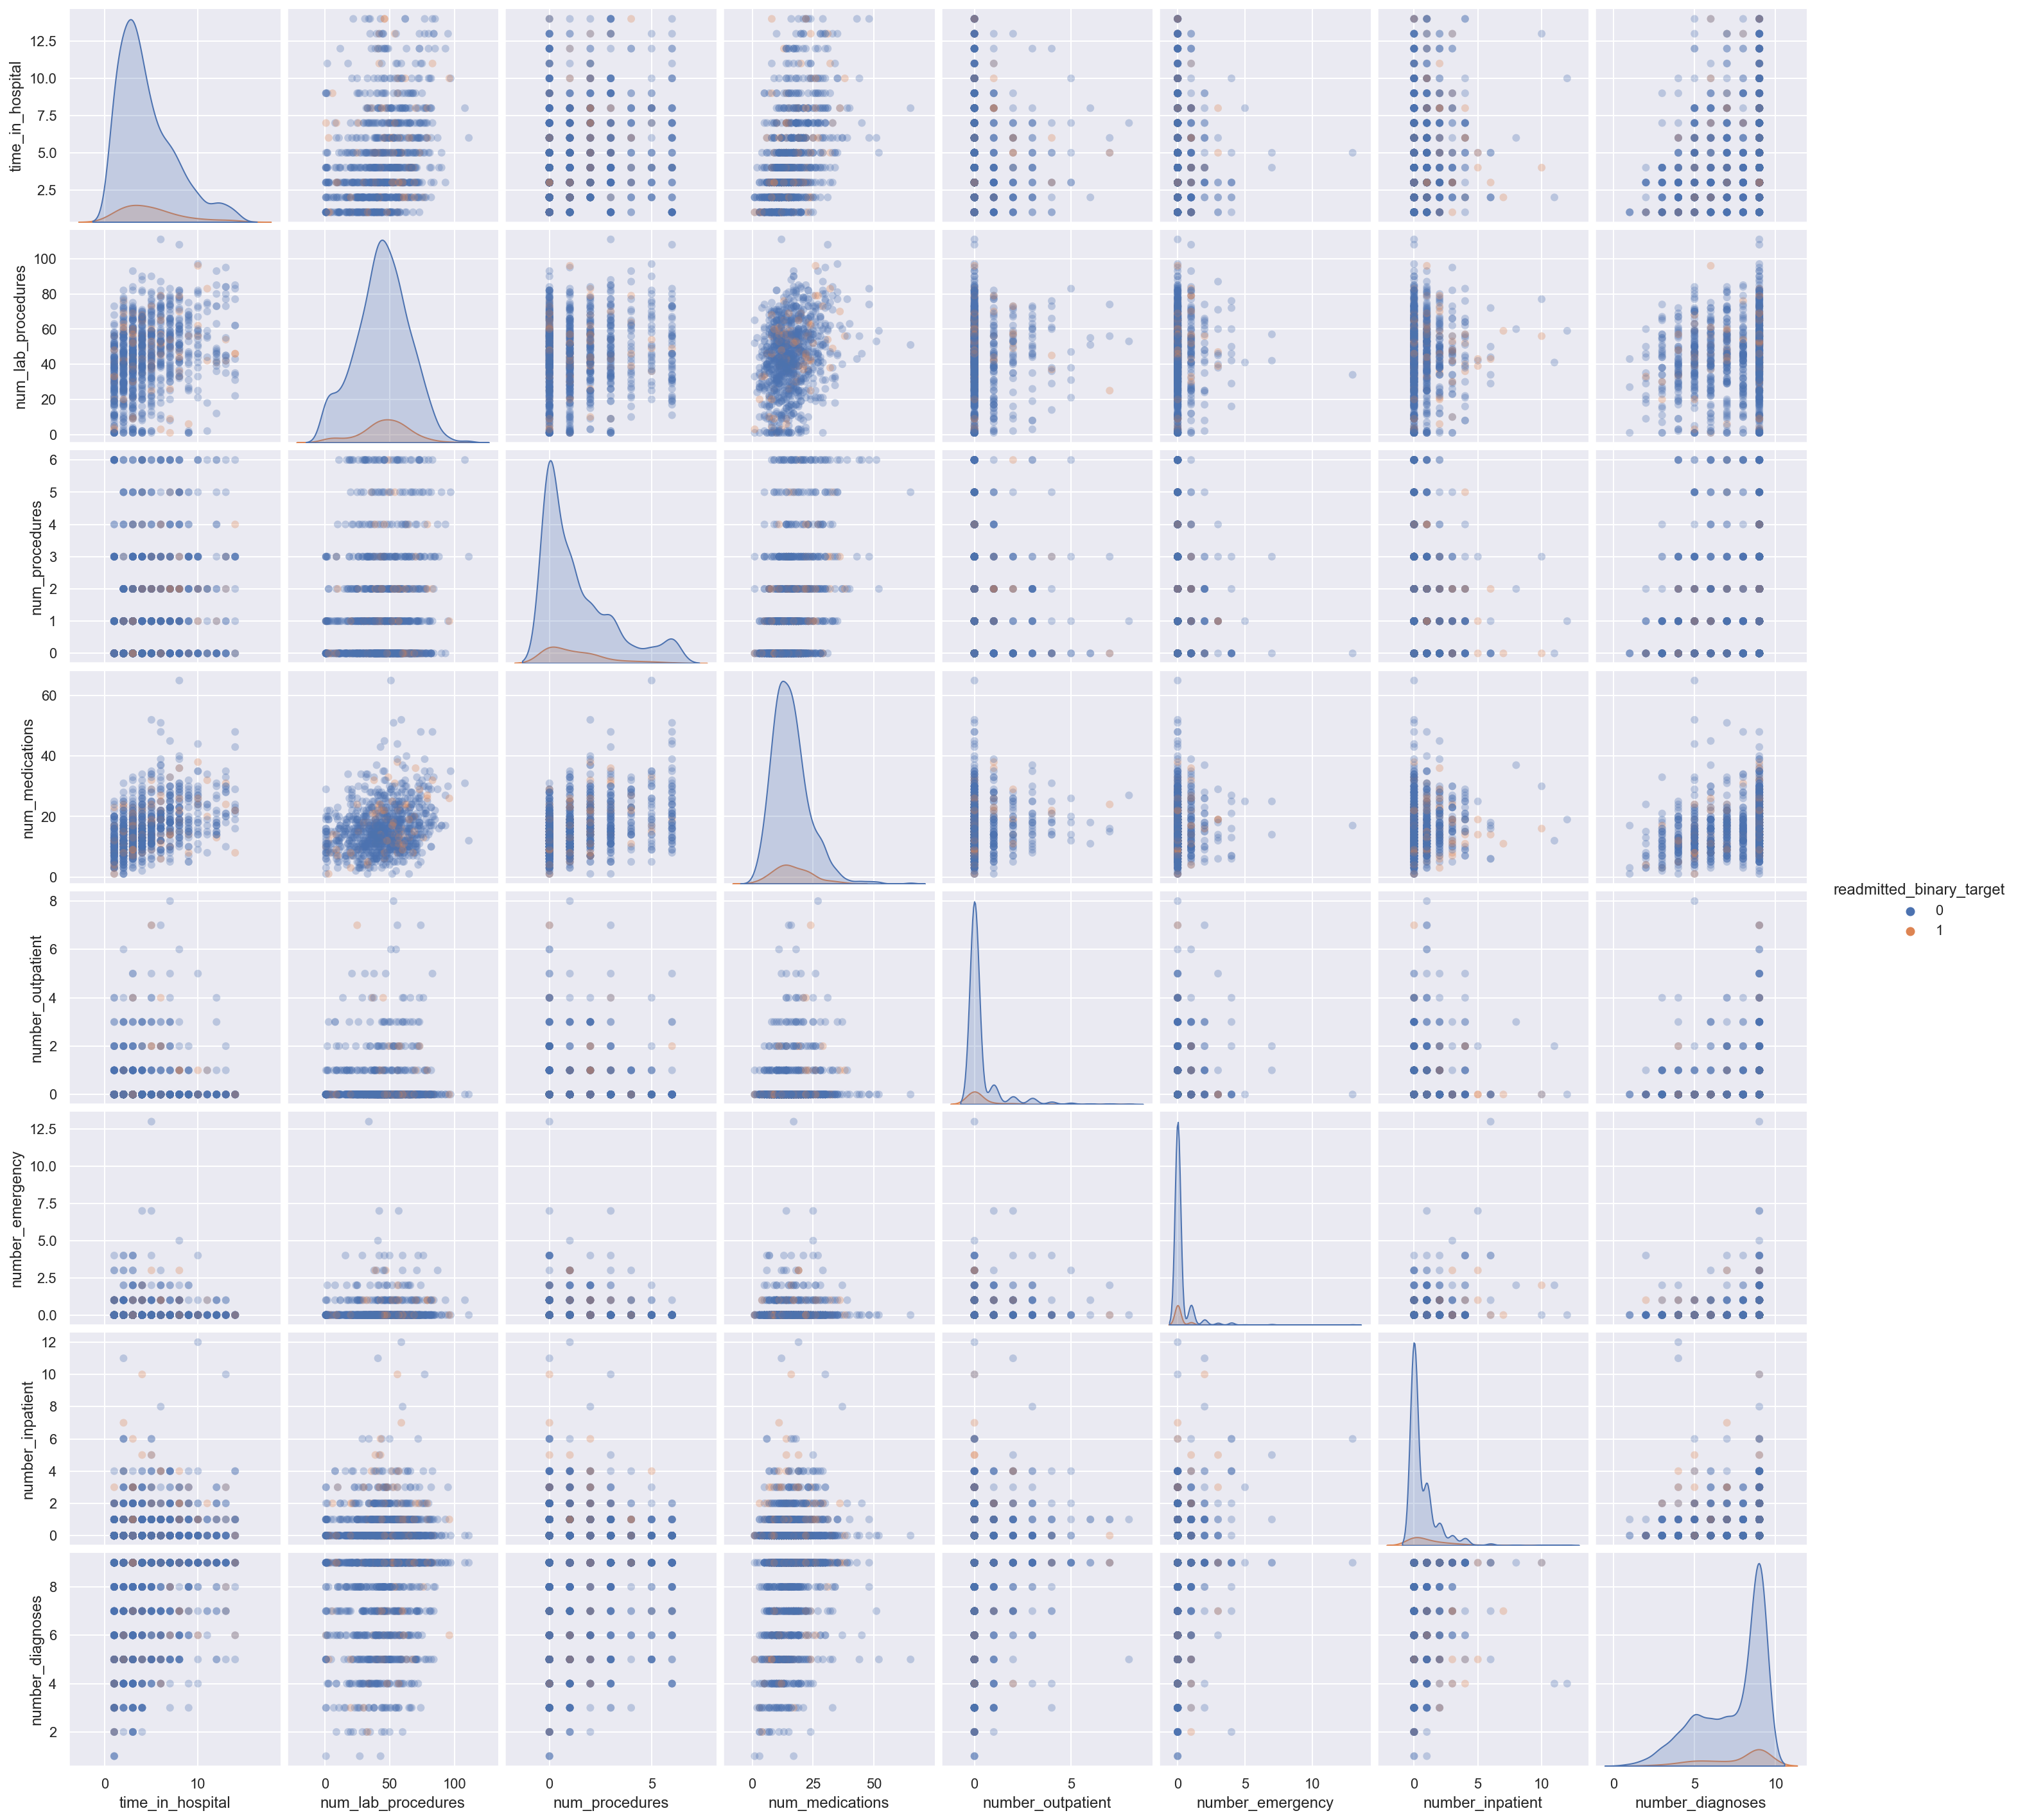

In [98]:
pairplot_features(training_validation_set,features_all_numerical)

As you can check above, unfortunately, the numerical features do not seem to linearly separate the target classes in any apparent way.  

- ### Running the Logistic regression model with 10-fold cross-validation:
    **Note**: GridSearchCV is not used in this step, as we are aiming for obtaining a single baseline model. 
    First, the function runs_model_with_10foldCV is defined:

In [99]:

def runs_model_with_10foldCV(model,training_df,features,scaling): # Perhaps this function is not necessary
    
    '''
    
    This function takes as inputs:
    1. The model - e.g., LogisticRegression()
    2. The training data. 
    3. The features of interest (no need to include the target feature, which is called within the function).
    4. Scaling 'yes, or 'no'. 
    
    - This function runs a 10-fold cross-validation with a predetermined split, which was defined when calling the function 'split_labels_10CV_no_bleeding'. 
    - As a reminder, this predetermined split guarantees that the observations corresponding to the same patient will always be in the same fold.
    - For each cross-validation (there are 10), this function calculates:
        (a) The F1 score obtained with the training data.
        (b) The F1 score obtained when validating the model.
        (c) The ROC-AUC score. 
        
        Also, for (a),(b) and (c) the mean and the standard deviation are computed.

    - Finally, the precision-recall curve is generated, superimposing the curves for each of the ten folds.
    
    '''
    
    
    # Convert the training data to numpy arrays. Note that by training data we mean the training-validation set, 
    # that 80% of the data that will be used for training and validating the model with 10-fold CV. 

    X_train = np.array(training_df[features])
    y_train = np.array(training_df['readmitted_binary_target']) 
    

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []
    
    
    # This Standardizes features by removing the mean and scaling to unit variance. 
    # Note that this is is not applied to the target feature.
    if scaling == 'yes':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)


    # This runs a 10-fold cross-validation:
    
    plt.figure(dpi=80)
    
    ct = 1
    for train_ind, val_ind in predetermined_10CV_split.split():   # iterates through the 10 splits and outputs numpy array indexes that will be used as masks within the loop. ##   train_ind, val_ind in predetermined_10CV_splits_noBleeding.split(X_train,y_train):   
        
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind] # training data for the current split.
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] # validation data for the current split.
        
        # Train the model:
        model.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        # Computes the F1 scores for the training set and the validation set, and the ROC-AUC curve, 
        # and appends each to its corresponding list:
        cv_F1_training.append(f1_score(y_train_fold, model.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, model.predict(X_val_fold)).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:,1]).round(3))

        # Plots the recall-Precision curve
        precision_curve, recall_curve, thresholds = precision_recall_curve(y_val_fold, model.predict_proba(X_val_fold)[:,1])
        plt.plot(thresholds, precision_curve[1:],label=f'precision{ct}')
        plt.plot(thresholds, recall_curve[1:], label=f'recall{ct}')
        # plt.legend(loc='lower left')
        plt.xlabel('Threshold (above this probability, label as a readmission)');
        plt.title('Precision and Recall Curves');

       
    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')



F1 training mean 10-fold cv: 0.030 +- 0.004
F1 validation mean 10-fold cv: 0.029 +- 0.030
ROC-AUC mean 10-fold cv: 0.627 +- 0.013


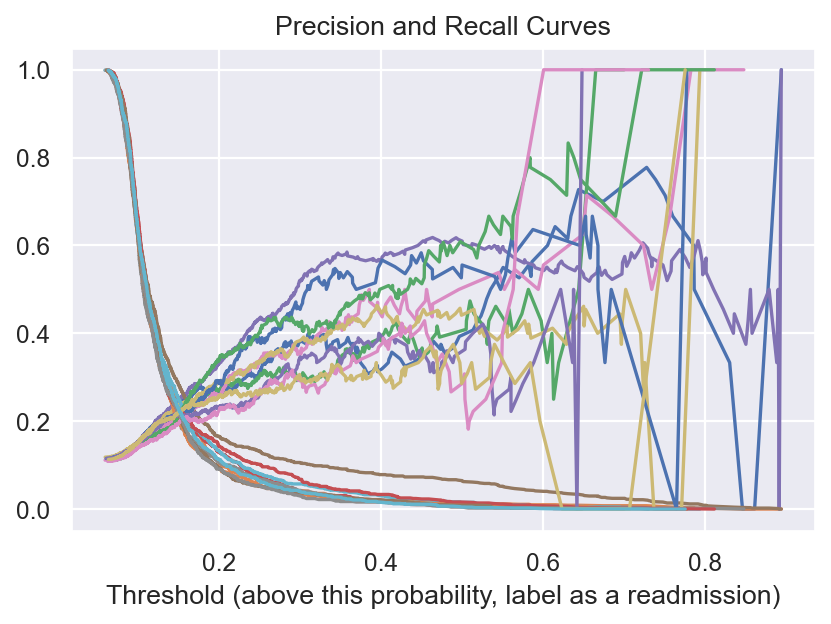

In [100]:
lr_model = LogisticRegression()
runs_model_with_10foldCV(lr_model,training_validation_set,features_all_numerical,scaling = 'yes')

# Logistic Regression (optimization)

Now that we have a baseline, the next step is to train **new models, and optimize them!** Several strategies are used:

### 1 - Numerical features only

Handling **class imbalance** with balanced weighting results in a huge increase in the F1 score:

F1 training mean 10-fold cv: 0.249 +- 0.001
F1 validation mean 10-fold cv: 0.249 +- 0.012
ROC-AUC mean 10-fold cv: 0.628 +- 0.013


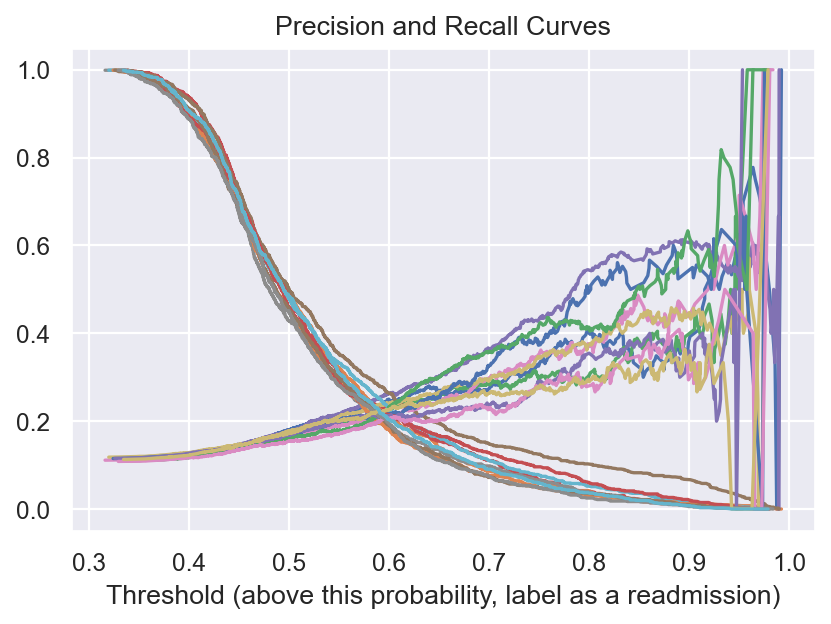

In [101]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

runs_model_with_10foldCV(LogisticRegression(class_weight='balanced'),training_validation_set,features_all_numerical,scaling = 'yes')

In [102]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
X_train_numerical = training_validation_set[features_all_numerical]
y_train_numerical = training_validation_set['readmitted_binary_target']


In [122]:
C_range = np.array([0.001,0.01,0.1,1.0,10.0,100.0])
param_grid_lr = [{'solver': ['lbfgs'],
                  'C': C_range, 'penalty': ['l2']},
                 {'solver': ['liblinear'],
                  'C': C_range, 'penalty': ['l1', 'l2']},
                 {'solver': ['sag'],
                  'C': C_range, 'penalty': ['l2']},
                 {'solver': ['saga'],
                  'C': C_range, 'penalty': ['l1','l2']}]



In [121]:
scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train_numerical)

In [123]:
gridcv_lr = GridSearchCV(LogisticRegression(class_weight = 'balanced'), param_grid_lr, cv=predetermined_10CV_split, return_train_score=True,scoring = 'f1')
gridcv_lr.fit(X_train_numerical, y_train_numerical)

GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 2, ..., 9, 6])),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2'], 'solver': ['saga']}],
             return_train_score=True, scoring='f1')

In [124]:
gridcv_lr.best_score_

0.250793335801759

In [125]:
gridcv_lr.best_params_

{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}

In [126]:
gridcv_lr.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

### 2 - All features:



In [127]:
C_range = np.array([0.001,0.01,0.1,1.0,10.0,100.0])
param_grid_lr_allFeatures = [{'solver': ['lbfgs'],
                  'C': C_range, 'penalty': ['l2']},
                 {'solver': ['liblinear'],
                  'C': C_range, 'penalty': ['l1', 'l2']},
                 {'solver': ['sag'],
                  'C': C_range, 'penalty': ['l2']},
                 {'solver': ['saga'],
                  'C': C_range, 'penalty': ['l1','l2']}]


In [128]:
all_features = list(diabetic_data_with_dummies.columns)[15:] + features_all_numerical
X_train = training_validation_set[all_features]
y_train = training_validation_set['readmitted_binary_target']

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)


In [138]:
gridcv_lr_allFeatures = GridSearchCV(LogisticRegression(class_weight = 'balanced',max_iter=400), param_grid_lr_allFeatures, cv=predetermined_10CV_split, return_train_score=True,n_jobs= -1,scoring = 'f1',verbose=1)
gridcv_lr_allFeatures.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 2, ..., 9, 6])),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=400),
             n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2'], 'solver': ['saga']}],
             return_train_score=True, scoring='f1', verbose=1)

In [139]:
gridcv_lr_allFeatures.best_score_

0.25173776602468434

In [140]:
gridcv_lr_allFeatures.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

#### Take the best hyperparameters found with GridSearchCV and check that 10-fold CV (without GridSearchCV) also improves the F1 score.

This step is a sanity check and it is not necessary.

F1 training mean 10-fold cv: 0.256 +- 0.001
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012


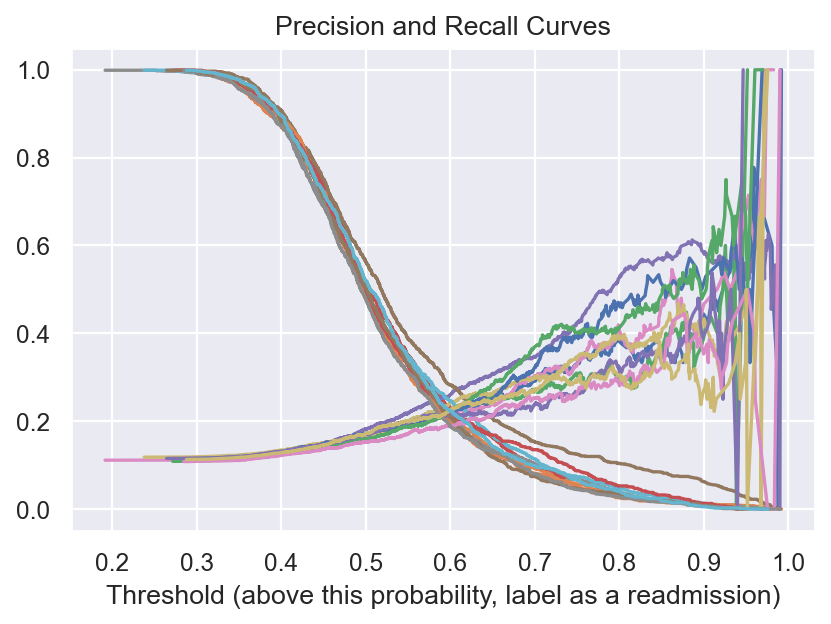

In [141]:
runs_model_with_10foldCV(LogisticRegression(class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga',max_iter=1000),training_validation_set,all_features,scaling = 'yes')

I want now to check which are the most relevant coefficients, by only using the training set with the same 10 fold cross-validation. This could potentially inform about additional feature engineering:

In [142]:
# Check the most relevant features: 

def finds_coefficients_cv(model,training_df,features,scaling):
    
    X_train = np.array(training_df[features])
    y_train = np.array(training_df['readmitted_binary_target'])

    if scaling == 'yes':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    
    ct = 1
    for train_ind, val_ind in predetermined_10CV_split.split(X_train,y_train):  
        
        
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
        lr_model = model.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

        if ct == 1:
            
            coefficients = lr_model.coef_.T
        else: 
            coefficients += lr_model.coef_.T
            
        plt.plot(coefficients)
        plt.xticks(range(len(features)),features, rotation=90)
        plt.xlabel('Feature')
        plt.ylabel("Coefficient magnitude")
                
    return lr_model.coef_.T
    
    


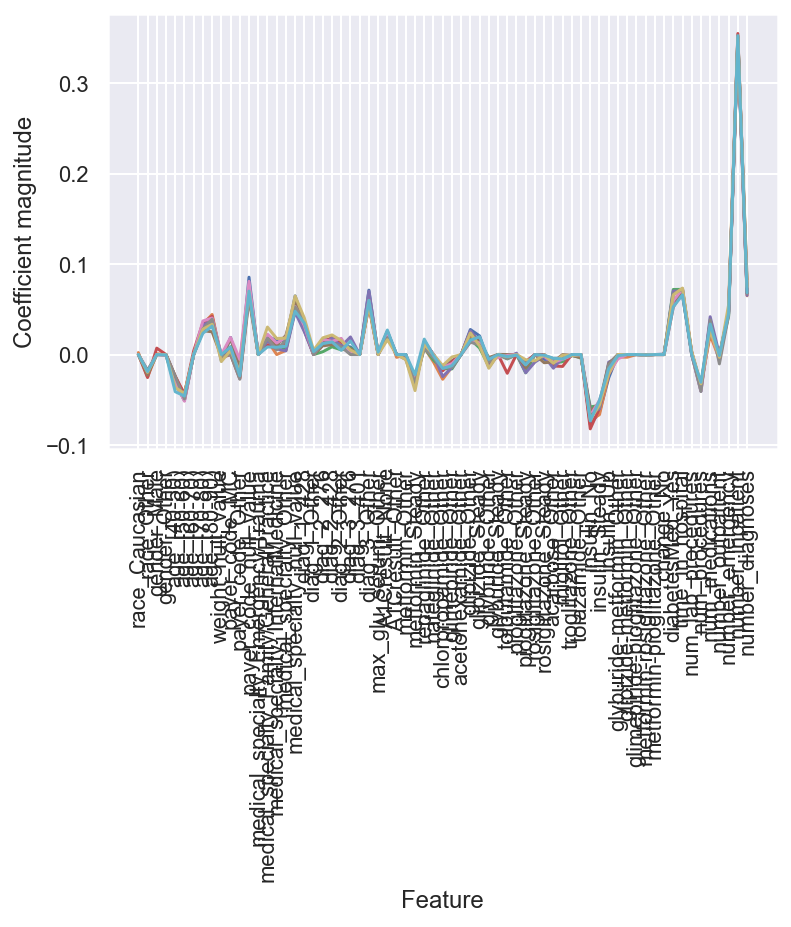

In [143]:

coef_lr = finds_coefficients_cv(LogisticRegression(class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga', max_iter=800),training_validation_set,all_features,scaling = 'yes')



In [144]:
lr_coefficients = pd.DataFrame({'feature_names': all_features, 'coefficients': list(coef_lr)}, columns = ['feature_names','coefficients'])

In [145]:
# I could technically use the coefficients with the largest negative or positive beta coefficients for the Random Forests model.
lr_coefficients.sort_values('coefficients',ascending = False)

,feature_names,coefficients
65,number_inpatient,[0.3523948286697708]
12,payer_code_null_value,[0.07015246094637242]
66,number_diagnoses,[0.0684534849492745]
59,time_in_hospital,[0.06594258199121776]
25,diag_3_Other,[0.05987199285095846]
...,...,...
61,num_procedures,[-0.03063517727731824]
4,age_[40-50),[-0.04108643795995287]
5,age_[50-60),[-0.04589322238469978]
50,insulin_Steady,[-0.050507286999364014]


### 3 - Add class-weighting to gridsearchCV as a new parameter. 

Here, I tried to tune the hyperparameter 'class_weight'. With the previous results, I assume that C is somewhere between 0.001 and 0.1.

In [180]:

C_range = np.array([0.001,0.01,0.1])
# C_range = np.arange(.4,.7,0.01)

param_grid_lr_allFeatures = [{'solver': ['lbfgs'],
                  'C': C_range, 'penalty': ['l2'],'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20}]},
                 {'solver': ['liblinear'],
                  'C': C_range, 'penalty': ['l1', 'l2'],'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20}]},
                 {'solver': ['sag'],
                  'C': C_range, 'penalty': ['l2'],'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20}]},
                 {'solver': ['saga'],
                  'C': C_range, 'penalty': ['l1','l2'],'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20}]}]



In [182]:
all_features = list(diabetic_data_with_dummies.columns)[15:] + features_all_numerical
X_train = training_validation_set[all_features]
y_train = training_validation_set['readmitted_binary_target']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)




In [130]:
gridcv_lr_allFeatures = GridSearchCV(LogisticRegression(max_iter = 4000,random_state = 42), param_grid_lr_allFeatures, cv=predetermined_10CV_split, return_train_score=True,n_jobs=-1,scoring = 'f1',verbose=1)
gridcv_lr_allFeatures.fit(X_train, y_train)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 2, ..., 9, 6])),
             estimator=LogisticRegression(max_iter=4000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': array([0.001, 0.01 , 0.1  ]),
                          'class_weight': ['balanced', {1: 2}, {1: 3}, {1: 4},
                                           {1: 5}, {1: 10}, {1: 20}],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([0.001, 0.01 , 0.1  ]),
                          'class_weight': ['balanced', {1: 2}, {1: 3}, {1: 4...
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': array([0.001, 0.01 , 0.1  ]),
                          'class_weight': ['balanced', {1: 2}, {1: 3}, {1: 4},
                                           {1: 5}, {1: 10}, {1: 20}],
                          'penalty': ['l2'], 'solver': ['sag']},
                         {'C': array([0.001, 0.01 , 0.1  ]),
 

In [151]:
gridcv_lr_allFeatures.best_score_

0.25173776602468434

In [153]:
gridcv_lr_allFeatures.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Ok, so no change here! class_weight: 'balanced' seems to be again the best option. I will keep it. I reduced the C options to 0.001,0.01, and 0.1 (based on the previous gridsearchCV) for a faster computation.  

### Explore if C is somewhere between 0.001 and 0.1 ! Plot all matrix.

### 4 - Once you find the best parameters, then check if oversampling helps (also, cross-validate it!)

Now, we do have the best paramenter combination: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}. We will check now if the scores improve when oversampling as well.
For the sake of a faster computation, we'll use again the current best parameter combination. 

In [147]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE 

In [151]:
def runs_model_with_10foldCV_oversampling(model,training_df,features,scaling,type_oversampling): # Perhaps this function is not necessary
    
    '''
    
    This function takes the model, the features of interest (no need to include every time the target feature).
    It runs a 10-fold cross-validation with a predetermined split, generated before, with no data bleeding.
    For each fold, this function calculates the F1 score for the training data, the F1 score for the validation,
    and the ROC-AUC score. For all these folds and scores, the mean and standard deviation are calculated. 
    Finally, the precision-recall curve is generated, superimposing the curves for each of the ten folds. Oversampling with SMOTE or RandomOverSampler.
    
    '''

    X_train = np.array(training_df[features])
    y_train = np.array(training_df['readmitted_binary_target'])


    if scaling == 'yes':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)


    
    for i in range(1,8): # We will check 8 possible multipliers to check which oversampling is the best. 
        
        cv_F1_training = []
        cv_ROC_AUC = []
        cv_F1_validation = []        
        
        
        for train_ind, val_ind in predetermined_10CV_split.split(X_train,y_train):   

            X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
            X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

            # setup for the ratio argument of RandomOverSampler initialization
            n_pos = np.sum(y_train_fold == 1)
            n_neg = np.sum(y_train_fold == 0)
            ratio = {1 : n_pos * i, 0 : n_neg} 

            if type_oversampling == 'SMOTE':
                smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
                X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)
            elif type_oversampling == 'RandomOverSampler':
            # randomly oversample positive samples: create 4x as many 
                ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
                X_train_fold, y_train_fold = ROS.fit_resample(X_train_fold, y_train_fold)

            model.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.

            cv_F1_training.append(f1_score(y_train_fold, model.predict(X_train_fold)).round(3))
            cv_F1_validation.append(f1_score(y_val_fold, model.predict(X_val_fold)).round(3))
            cv_ROC_AUC.append(roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:,1]).round(3))

#             # Recall-Precision curve
#             precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_fold, model.predict_proba(X_val_fold)[:,1])
#             plt.plot(threshold_curve, precision_curve[1:],label=f'precision{ct}')
#             plt.plot(threshold_curve, recall_curve[1:], label=f'recall{ct}')
#             # plt.legend(loc='lower left')
#             plt.xlabel('Threshold (above this probability, label as a readmission)');
#             plt.title('Precision and Recall Curves');

        print(i)
        print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
        print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
        print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')




In [155]:
runs_model_with_10foldCV_oversampling(LogisticRegression(max_iter = 8000,class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga'),training_validation_set,all_features,scaling = 'yes',type_oversampling = 'RandomOverSampler')


1
F1 training mean 10-fold cv: 0.256 +- 0.001
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
2
F1 training mean 10-fold cv: 0.373 +- 0.002
F1 validation mean 10-fold cv: 0.252 +- 0.011
ROC-AUC mean 10-fold cv: 0.635 +- 0.012
3
F1 training mean 10-fold cv: 0.439 +- 0.003
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
4
F1 training mean 10-fold cv: 0.482 +- 0.002
F1 validation mean 10-fold cv: 0.252 +- 0.009
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
5
F1 training mean 10-fold cv: 0.512 +- 0.002
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
6
F1 training mean 10-fold cv: 0.534 +- 0.003
F1 validation mean 10-fold cv: 0.251 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
7
F1 training mean 10-fold cv: 0.551 +- 0.003
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012


In [157]:
runs_model_with_10foldCV_oversampling(LogisticRegression(class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga',max_iter = 8000),training_validation_set,all_features,scaling = 'yes',type_oversampling = 'SMOTE')


1
F1 training mean 10-fold cv: 0.256 +- 0.001
F1 validation mean 10-fold cv: 0.252 +- 0.010
ROC-AUC mean 10-fold cv: 0.636 +- 0.012
2
F1 training mean 10-fold cv: 0.383 +- 0.002
F1 validation mean 10-fold cv: 0.250 +- 0.011
ROC-AUC mean 10-fold cv: 0.632 +- 0.013
3
F1 training mean 10-fold cv: 0.458 +- 0.001
F1 validation mean 10-fold cv: 0.248 +- 0.011
ROC-AUC mean 10-fold cv: 0.629 +- 0.013
4
F1 training mean 10-fold cv: 0.508 +- 0.002
F1 validation mean 10-fold cv: 0.247 +- 0.009
ROC-AUC mean 10-fold cv: 0.628 +- 0.013
5
F1 training mean 10-fold cv: 0.543 +- 0.001
F1 validation mean 10-fold cv: 0.246 +- 0.009
ROC-AUC mean 10-fold cv: 0.627 +- 0.013
6
F1 training mean 10-fold cv: 0.570 +- 0.002
F1 validation mean 10-fold cv: 0.246 +- 0.008
ROC-AUC mean 10-fold cv: 0.627 +- 0.013
7
F1 training mean 10-fold cv: 0.590 +- 0.001
F1 validation mean 10-fold cv: 0.245 +- 0.008
ROC-AUC mean 10-fold cv: 0.626 +- 0.013


There is no improvement! While the training F1 score improves, the validation F1 worsens. For this reason, I will handle class imbalance by just introducing the parameter class_weight = 'balanced'.

### 5 - Also check which is the best threshold. Do we get any improvements?

In [160]:
def runs_model_with_thresholds_cv(model,training_df,features,scaling): # Perhaps this function is not necessary
    
    '''
    
    This function takes the model, the features of interest (no need to include every time the target feature).
    It runs a 10-fold cross-validation with a predetermined split, generated before, with no data bleeding.
    For each fold, this function calculates the F1 score for the training data, the F1 score for the validation,
    and the ROC-AUC score. For all these folds and scores, the mean and standard deviation are calculated. 
    Finally, the precision-recall curve is generated, superimposing the curves for each of the ten folds.
    
    '''

    X_train = np.array(training_df[features])
    y_train = np.array(training_df['readmitted_binary_target'])
    
    
    if scaling == 'yes':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)


    plt.figure(dpi=80)
    sns.set()
    ct = 1
    best_score = [ ]
    best_threshold = [ ]
    for train_ind, val_ind in predetermined_10CV_split.split(X_train,y_train):   
        
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
        
        model.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
        
        thresh_ps = np.linspace(.10,1.0,1000)
        model_val_probs = model.predict_proba(X_val_fold)[:,1] # positive class probs, same basic logistic model we fit in section 2 
        
        f1_scores = []
        for p in thresh_ps:
            model_val_labels = model_val_probs >= p
            f1_scores.append(f1_score(y_val_fold, model_val_labels))    

        best_score.append(np.max(f1_scores))
        best_threshold.append(thresh_ps[np.argmax(f1_scores)])
        
        
    print(f'Best F1 score 10-fold cv: {np.mean(best_score):.3f} +- {np.std(best_score):.3f}')
    print(f'Best threshold mean 10-fold cv: {np.mean(best_threshold):.3f} +- {np.std(best_threshold):.3f}')



In [163]:
runs_model_with_thresholds_cv(LogisticRegression(class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga',max_iter = 400),training_validation_set,all_features,scaling = 'yes')

Best F1 score 10-fold cv: 0.257 +- 0.012
Best threshold mean 10-fold cv: 0.513 +- 0.030


<Figure size 480x320 with 0 Axes>

Let's now check now with best threshold mean 0.513:

In [167]:
def runs_model_with_10foldCV_thesholdUpdated(model,training_df,features,scaling): # Perhaps this function is not necessary
    
    '''
    
    This function takes the model, the features of interest (no need to include every time the target feature).
    It runs a 10-fold cross-validation with a predetermined split, generated before, with no data bleeding.
    For each fold, this function calculates the F1 score for the training data, the F1 score for the validation,
    and the ROC-AUC score. For all these folds and scores, the mean and standard deviation are calculated. 
    Finally, the precision-recall curve is generated, superimposing the curves for each of the ten folds.
    
    '''

    X_train = np.array(training_df[features])
    y_train = np.array(training_df['readmitted_binary_target'])
    

    cv_F1_training = []
    cv_ROC_AUC = []
    cv_F1_validation = []
    
    
    if scaling == 'yes':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)


    plt.figure(dpi=80)
    ct = 1
    for train_ind, val_ind in predetermined_10CV_split.split(X_train,y_train):   
        
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 
        

        model.fit(X_train_fold, y_train_fold.ravel()) # .ravel will convert the array from shape (n,1) to (n, ). Otherwise we get a warning.
        
        model_val_probs = model.predict_proba(X_val_fold)[:,1]
        p = 0.513
        model_val_labels = model_val_probs >= p
        

        cv_F1_training.append(f1_score(y_train_fold, model.predict(X_train_fold)).round(3))
        cv_F1_validation.append(f1_score(y_val_fold, model_val_labels).round(3))
        cv_ROC_AUC.append(roc_auc_score(y_val_fold, model_val_labels).round(3))


       
    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'ROC-AUC mean 10-fold cv: {np.mean(cv_ROC_AUC):.3f} +- {np.std(cv_ROC_AUC):.3f}')




In [168]:
runs_model_with_10foldCV_thesholdUpdated(LogisticRegression(class_weight='balanced', C = 0.01, penalty = 'l1', solver = 'saga',max_iter = 400),training_validation_set,all_features,scaling = 'yes')


F1 training mean 10-fold cv: 0.256 +- 0.001
F1 validation mean 10-fold cv: 0.252 +- 0.014
ROC-AUC mean 10-fold cv: 0.591 +- 0.013


<Figure size 480x320 with 0 Axes>

No improvement was observed when updating the probability threshold to 0.513. So that's it, we'll leave it at class_weight = 'balanced', that gave the best results before. 

### 6 - Improve the feature engineering?

This was an early attempt to investigate if feature engineering could be improved by creating more classes for categorical variables like 'diag_3', which have many classes. Remember that those classes that accounted for fewer than 5% of the observations were grouped into the class 'Other'. As seen above, one of the features contributing to the model more is 'diag_3_Other'. It is obvious to me that this condition contains important information. Below I count how many classes (before grouping them into the 'Other' class had a mean target of above 0.6. Those classes would be clearly related with the positive target class. Unfortunatelyt, 0.023% of the observations meet this criteria. With just a few observations, it does not make sense in my opinion to make them into a class, as there is the chance that observation meeting that criteria are so few that they are not even assigned to the test or validation sets. For this reason, I decided not to implement any of these feature engineering modifications.

In [169]:
def percentage_counts(row):
    return row/sumCount*100

In [172]:
data = diabetic_data.groupby(['diag_3'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()
sumCount = data['count'].sum()

data['count'] = data['count'].apply(percentage_counts) 
data.rename(columns = {'count': 'percentage'},inplace = True)
data.sort_values('mean',ascending=False,inplace=True)
# data.head(20)
data[data['mean'] >= 0.6].percentage.sum()

0.022921379667739654

# Random forests models


I will some insights from the linear regression model, like using class_weight = 'balanced' as a way to handle class imbalance. I will use gridsearchCV to optimize hyperparameters.

### 1- With all numerical features: cross validation / 10-fold CV / imbalancing: weighting at training, the validation performance is very low and there is a lot of overfitting:

F1 training mean 10-fold cv: 0.942 +- 0.001
F1 validation mean 10-fold cv: 0.042 +- 0.006
ROC-AUC mean 10-fold cv: 0.573 +- 0.007


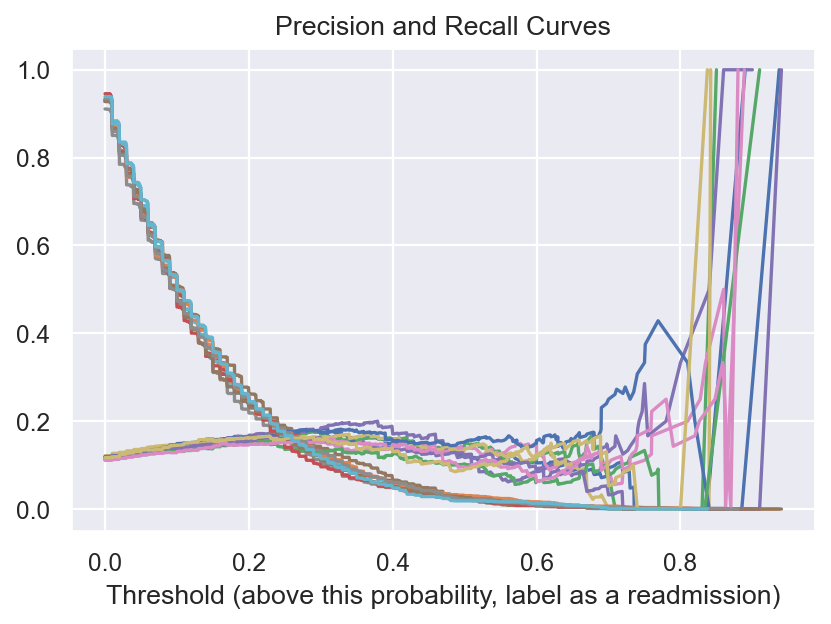

In [383]:
features_all_numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced')
runs_model_with_10foldCV(forest_balanced,features_all_numerical,scaling = 'no')

### 2 - All features

In [243]:
all_features = list(diabetic_data_with_dummies.columns)[15:] + features_all_numerical
X_train_not_scaled = training_validation_set[all_features]
y_train = training_validation_set['readmitted_binary_target']



In [252]:
# Now, let's try more than 300!

param_grid = { 
    'n_estimators': [100,300,800,1000,1200,1500],
    'max_features': ['sqrt'],
    'max_depth': [5,10,12,15]
}

CV_rfc = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',random_state = 42),param_grid=param_grid, cv=predetermined_10CV_split,return_train_score=True,n_jobs=1,scoring = 'f1',verbose=2)
CV_rfc

GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 2, ..., 9, 6])),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 10, 12, 15], 'max_features': ['sqrt'],
                         'n_estimators': [100, 300, 800, 1000, 1200, 1500]},
             return_train_score=True, scoring='f1', verbose=2)

In [253]:
CV_rfc.fit(X_train_not_scaled, y_train)



Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.8s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.8s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.8s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.3s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=300; total time=   5.5s
[CV] END ...max_depth=5, max_features=sqrt, n_

GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 2, ..., 9, 6])),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 10, 12, 15], 'max_features': ['sqrt'],
                         'n_estimators': [100, 300, 800, 1000, 1200, 1500]},
             return_train_score=True, scoring='f1', verbose=2)

In [254]:
print(CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 800}


In [379]:
print(CV_rfc.best_score_)

0.2539617103802748


In [262]:
results = pd.DataFrame(CV_rfc.cv_results_)

In [ ]:
# Just check how does it perform with our previous analyses:
RF_optimized = RandomForestClassifier(n_estimators = 1000, max_depth = 10, random_state = 42, class_weight='balanced',max_features = 'sqrt')
runs_model_with_10foldCV(RF_optimized,training_validation_with_dummies,all_features,scaling = 'no')




# XGBoost

https://xgboost.readthedocs.io/en/stable/prediction.html

In [359]:
import itertools
lists_parameters = [[4,6,8,12],[0.01, 0.05, 0.1],[0.3, 0.7],[3,11]] # max_depth, learning_rate, colsample_bytree, min_child_weight
combination_parameters_to_tune = list(itertools.product(*lists_parameters))


In [376]:

def xgboost_10fold_cv(diabetic_data_with_dummies,features_all_numerical,predetermined_10CV_split,list_parameters):
    
    all_features = list(diabetic_data_with_dummies.columns)[15:] + features_all_numerical
    X_train = np.array(training_validation_set[all_features])
    y_train = np.array(training_validation_set['readmitted_binary_target'])

    cv_F1_training = [] 
    cv_F1_validation = [] 
    cv_best_ntree_limit = [] 

    for train_ind, val_ind in predetermined_10CV_split.split(X_train,y_train):   
        X_train_fold, y_train_fold = X_train[train_ind], y_train[train_ind]
        X_val_fold, y_val_fold = X_train[val_ind], y_train[val_ind] 

        gbm = xgb.sklearn.XGBClassifier(scale_pos_weight=8,use_label_encoder=False, 
                            n_estimators=30000,
                            max_depth=list_parameters[0],
                            objective='binary:logistic', 
                            learning_rate=list_parameters[1], 
                            subsample=.8,
                            colsample_bytree=list_parameters[2],
                            min_child_weight=list_parameters[3]
                           )
        eval_set=[(X_train_fold,y_train_fold),(X_val_fold,y_val_fold)]

        fit_xgb_model= gbm.fit( 
                        X_train_fold, y_train_fold, 
                        eval_set=eval_set,
                        eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                        early_stopping_rounds=50,
                        verbose=False
                       )   

        cv_F1_training.append(f1_score(y_train_fold, fit_xgb_model.predict(X_train_fold)))
        cv_F1_validation.append(f1_score(y_val_fold, fit_xgb_model.predict(X_val_fold)))
        cv_best_ntree_limit.append(fit_xgb_model.best_ntree_limit)

        del X_train_fold, y_train_fold, X_val_fold, y_val_fold, eval_set

        
    print(f'max depth:{list_parameters[0]}, learning rate: {list_parameters[1]}, colsample_bytree: {list_parameters[2]}, min_child_weight: {list_parameters[3]}')
    print(f'F1 training mean 10-fold cv: {np.mean(cv_F1_training):.3f} +- {np.std(cv_F1_training):.3f}')
    print(f'F1 validation mean 10-fold cv: {np.mean(cv_F1_validation):.3f} +- {np.std(cv_F1_validation):.3f}')
    print(f'best tree limit mean 10-fold cv: {np.mean(cv_best_ntree_limit):.3f} +- {np.std(cv_best_ntree_limit):.3f}')


In [377]:
for i in range(len(combination_parameters_to_tune)):
    print(f'combination number {i}')
    xgboost_10fold_cv(diabetic_data_with_dummies,features_all_numerical,predetermined_10CV_split,combination_parameters_to_tune[i])


combination number 0
max depth:4, learning rate: 0.01, colsample_bytree: 0.3, min_child_weight: 3
F1 training mean 10-fold cv: 0.257 +- 0.006
F1 validation mean 10-fold cv: 0.250 +- 0.009
best tree limit mean 10-fold cv: 112.300 +- 136.787
combination number 1
max depth:4, learning rate: 0.01, colsample_bytree: 0.3, min_child_weight: 11
F1 training mean 10-fold cv: 0.255 +- 0.004
F1 validation mean 10-fold cv: 0.250 +- 0.009
best tree limit mean 10-fold cv: 62.700 +- 74.758
combination number 2
max depth:4, learning rate: 0.01, colsample_bytree: 0.7, min_child_weight: 3
F1 training mean 10-fold cv: 0.256 +- 0.002
F1 validation mean 10-fold cv: 0.251 +- 0.011
best tree limit mean 10-fold cv: 56.400 +- 45.142
combination number 3
max depth:4, learning rate: 0.01, colsample_bytree: 0.7, min_child_weight: 11
F1 training mean 10-fold cv: 0.256 +- 0.002
F1 validation mean 10-fold cv: 0.251 +- 0.011
best tree limit mean 10-fold cv: 56.200 +- 45.055
combination number 4
max depth:4, learning r

# Testing the models with the test set:

## Final baseline model performance:

In [387]:

X_train_numerical = training_validation_set[features_all_numerical]
y_train_numerical = training_validation_set['readmitted_binary_target']


X_test_numerical = test_set[features_all_numerical]
y_test_numerical = test_set['readmitted_binary_target']

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train_numerical)
X_test_numerical = scaler.fit_transform(X_test_numerical)



lr_baseline = LogisticRegression()
lr_baseline.fit(X_train_numerical,y_train_numerical)
print("Train set score: {:.3f}".format(f1_score(y_test_numerical, lr_baseline.predict(X_test_numerical))))



Train set score: 0.023


F1 test: 0.0225
ROC-AUC: 0.6369


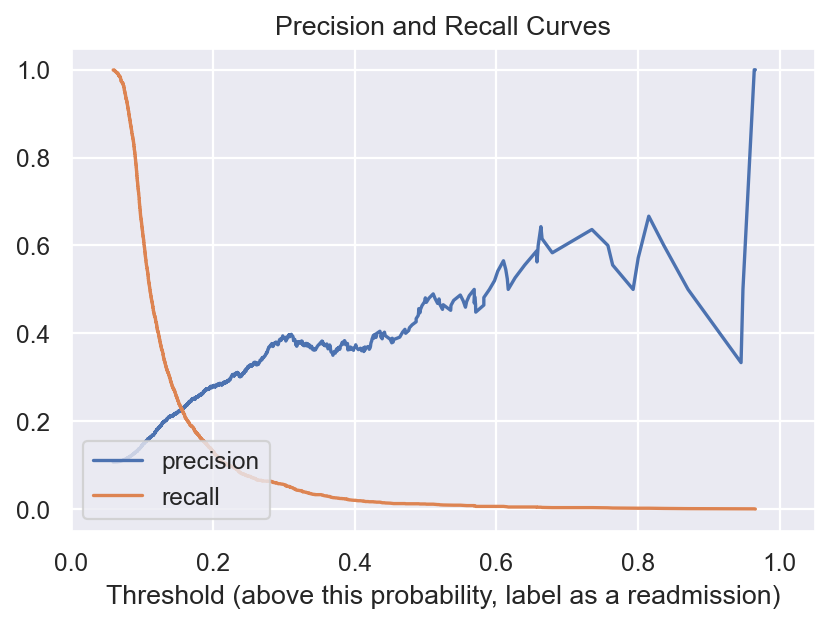

<Figure size 480x320 with 0 Axes>

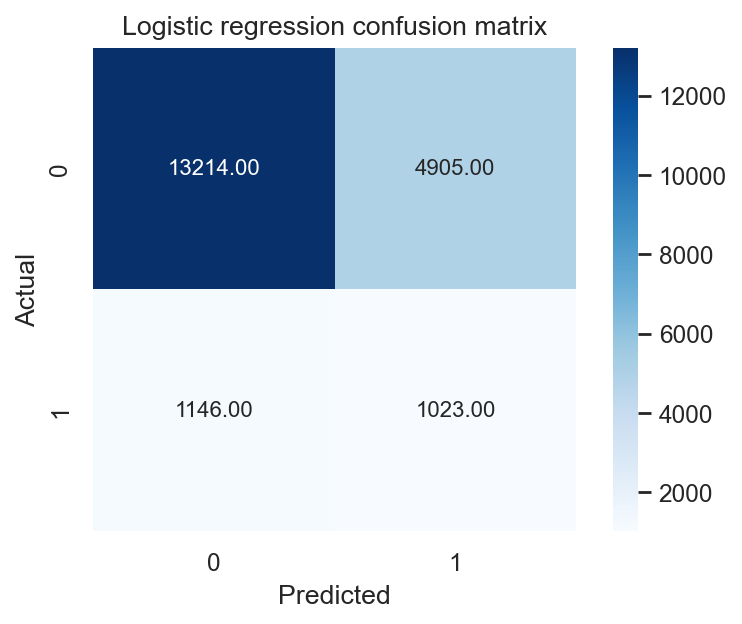

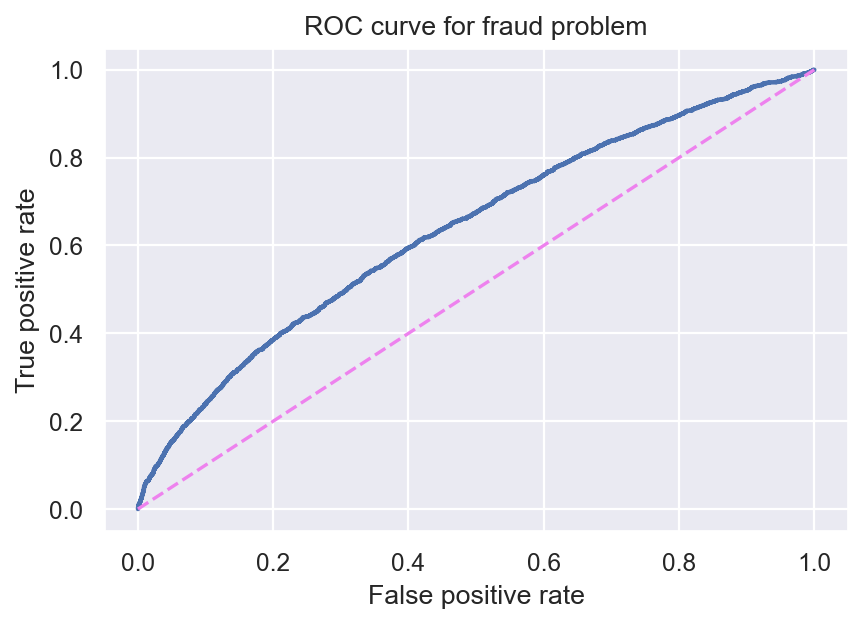

In [420]:
    print(f'F1 test: {f1_score(y_test_numerical, lr_baseline.predict(X_test_numerical)).round(4)}')
    print(f'ROC-AUC: {roc_auc_score(y_test_numerical, lr_baseline.predict_proba(X_test_numerical)[:,1]).round(4)}')

    # Recall-Precision curve
    plt.figure(dpi=80)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_numerical, lr_baseline.predict_proba(X_test_numerical)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.xlim([0.0,1.05])
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');

    # Confusion matrix
    plt.figure(dpi=80)
    confusion_baseline = confusion_matrix(y_test_numerical, lr_baseline.predict(X_test_numerical))
    plt.figure(dpi=80)
    # Print confusion matrix for RF
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');
    
    
    # ROC-AUC curv
    plt.figure(dpi=80)
    fpr1_baseline, tpr1_baseline, thresholds = roc_curve(y_test_numerical, lr_baseline.predict_proba(X_test_numerical)[:,1])
    plt.plot(fpr1_baseline, tpr1_baseline,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for fraud problem');    

## Final Linear Regression model score

In [400]:
X_test = test_set[all_features]
y_test = test_set['readmitted_binary_target']

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

print("Test set score: {:.3f}".format(gridcv_lr_allFeatures.score(X_test,y_test)))

Test set score: 0.248


## Final Random forests model score, confusion matrix.

In [401]:
X_test = test_set[all_features]
y_test = test_set['readmitted_binary_target']



print("Test set score: {:.3f}".format(CV_rfc.score(X_test,y_test)))
print(f'ROC-AUC: {roc_auc_score(y_test, CV_rfc.predict_proba(X_test)[:,1]).round(4)}')

Test set score: 0.253
ROC-AUC: 0.6453


F1 test: 0.2527
ROC-AUC: 0.6453


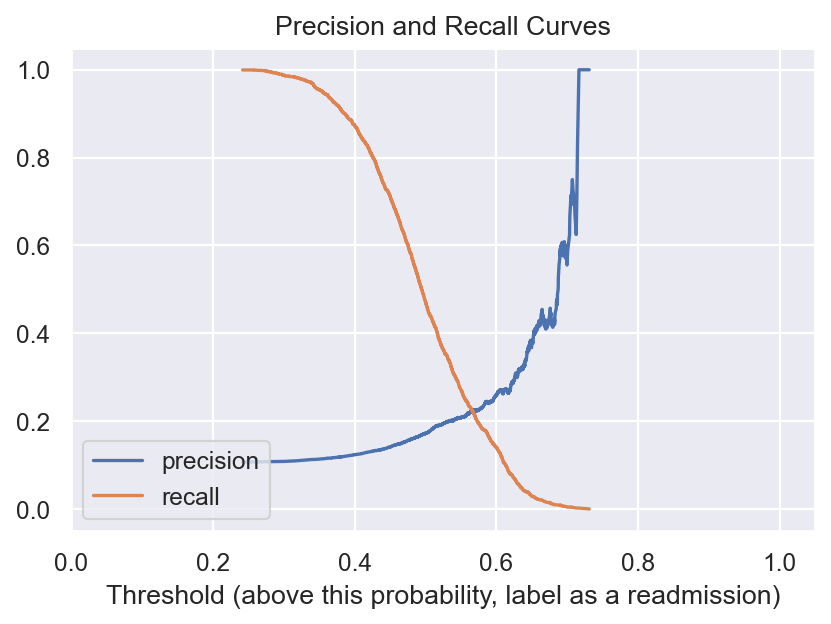

<Figure size 480x320 with 0 Axes>

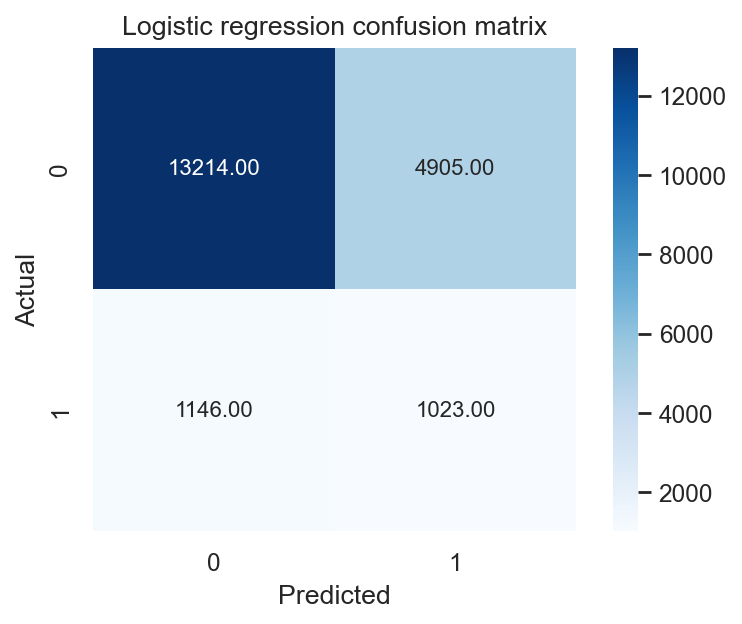

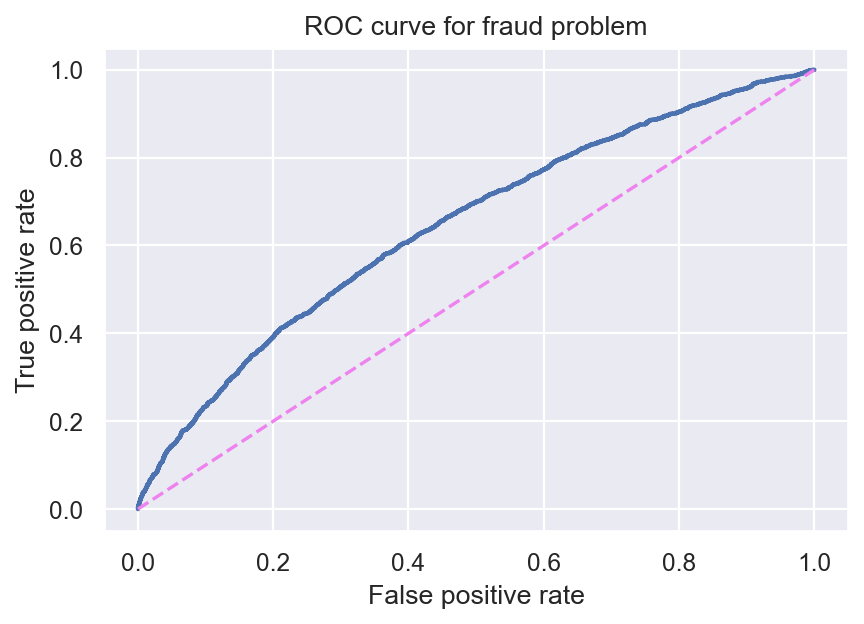

In [394]:


    # Recall-Precision curve
    plt.figure(dpi=80)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, CV_rfc.predict_proba(X_test)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.xlim([0.0,1.05])
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');

    # Confusion matrix
    plt.figure(dpi=80)
    confusion = confusion_matrix(y_test, CV_rfc.predict(X_test))
    plt.figure(dpi=80)
    # Print confusion matrix for RF
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');
    
    
    # ROC-AUC curve
    plt.figure(dpi=80)
    fpr1_RF, tpr1_RF, thresholds_RF = roc_curve(y_test, CV_rfc.predict_proba(X_test)[:,1])
    plt.plot(fpr1_RF, tpr1_RF,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for fraud problem');    

## Final XGBoost model score:

max depth:4, learning rate: 0.05, colsample_bytree: 0.3, min_child_weight: 11

In [408]:
    
#     all_features = list(diabetic_data_with_dummies.columns)[15:] + features_all_numerical
X_train = np.array(training_validation_set[all_features])
y_train = np.array(training_validation_set['readmitted_binary_target'])
X_test = np.array(test_set[all_features])
y_test = np.array(test_set['readmitted_binary_target'])




gbm = xgb.sklearn.XGBClassifier(scale_pos_weight=8,use_label_encoder=False, 
                            n_estimators=30000,
                            max_depth=4,
                            objective='binary:logistic', 
                            learning_rate=0.05, 
                            subsample=.8,
                            colsample_bytree=0.3,
                            min_child_weight=11
                           )
eval_set=[(X_train,y_train),(X_test,y_test)]

fit_xgb_model= gbm.fit( 
                        X_train, y_train, 
                        eval_set=eval_set,
                        eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                        early_stopping_rounds=50,
                        verbose=False
                       )   

F1_training_xgb = f1_score(y_train, fit_xgb_model.predict(X_train))
F1_test_xgb = f1_score(y_test, fit_xgb_model.predict(X_test))
       

/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [411]:
F1_training_xgb

0.2599990038352344

In [409]:
F1_test_xgb

0.2490985886473679

So, the random forests model was the one that performed better!

# Confusion Matrix, interpretation:

In [395]:
TP = confusion[1][1] # True positive
FN = confusion[1][0] # False negative

TN = confusion[0][0] # True negative
FP = confusion[0][1] # False positive


#### True positive rate (or recall):

In [396]:
TP/(TP+FN) 

0.47164591977869985

#### In the example, for 100 patients that will be readmitted, the model detects: ~ 47 patients


In [421]:
TP_example = TP/(TP+FN)*100
TP_example

47.16459197786998

In [397]:
# this is the ratio between negatives and positives:
(TN+FP)/(TP+FN) # There are ~127 times more 

8.353619179345321

In [412]:
# So, if every patient takes 30 min, perfect accuracy and recall means that it would take us:
duration = 100*0.5
'{} hours'.format(duration)

'50.0 hours'

So, what would be the cost in hours to reach these 47 patients? It would be that of reaching to all the patients predicted to be positive (readmitted).
We have decided that TP + FN (all true positives) will be a 100 patients. We now need to find how does it translate to
the FP value. 
FP/(TP+FN)*100 will find us how many FP our model will have if TP+FN = 100





47.16459197786998

In [422]:
FP_example = FP/(TP+FN)*100 
FP_example

226.14107883817428

In [276]:
total_positives = (TP_example + FP_example)*0.5
total_positives

136.09958506224066

In [415]:
TN_example = TN/(TP+FN)*100 
TN_example*0.5
total_time = (100+FP_example+TN_example)*0.5 
total_time

467.680958967266

In [417]:
Total = 100+TN_example*0.5

In [419]:
total_positives = (TP_example + FP_example)*0.5
total_positives

136.65283540802213

In [418]:
sum(y_test)

2169

In [252]:
len(y_test)

20288

# And now, find the number of hours invested in a naive model.     

In [ ]:
# Linear Regression:

In [133]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)



print("Test set score: {:.3f}".format(gridcv_lr_allFeatures.score(X_test_scaled,y_test)))





Test set score: 0.248


F1 test: 0.2481
ROC-AUC: 0.6428


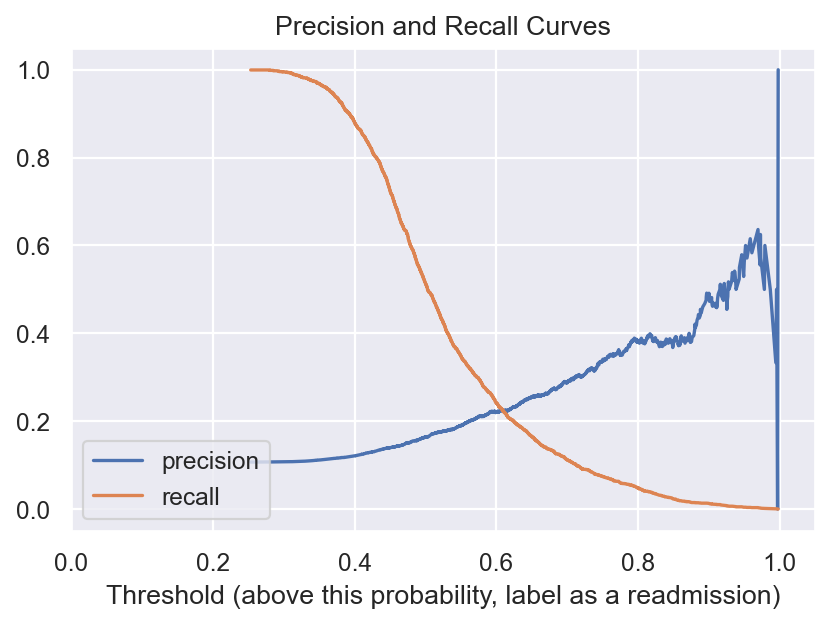

<Figure size 480x320 with 0 Axes>

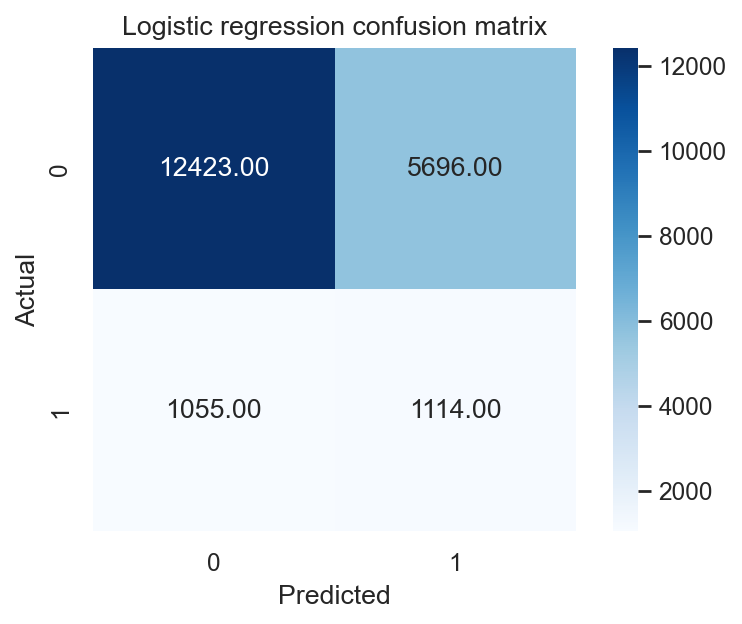

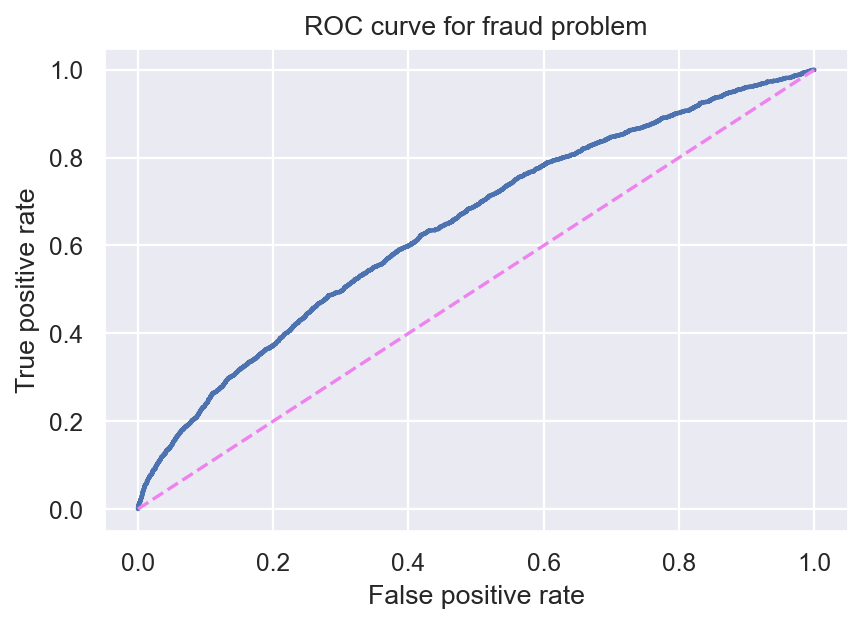

In [194]:
    
    print(f'F1 test: {f1_score(y_test, gridcv_lr_allFeatures.predict(X_test_scaled)).round(4)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, gridcv_lr_allFeatures.predict_proba(X_test_scaled)[:,1]).round(4)}')

    # Recall-Precision curve
    plt.figure(dpi=80)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, gridcv_lr_allFeatures.predict_proba(X_test_scaled)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.xlim([0.0,1.05])
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, label as a readmission)');
    plt.title('Precision and Recall Curves');

    # Confusion matrix
    plt.figure(dpi=80)
    confusion = confusion_matrix(y_test, gridcv_lr_allFeatures.predict(X_test_scaled))
    plt.figure(dpi=80)
    # Print confusion matrix for RF
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='.2f') # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');
    
    
    # ROC-AUC curve
    plt.figure(dpi=80)
    fpr1_LR, tpr1_LR, thresholds_LR = roc_curve(y_test, gridcv_lr_allFeatures.predict_proba(X_test_scaled)[:,1])
    plt.plot(fpr1_LR, tpr1_LR,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for fraud problem');    

In [ ]:
# ROC curve plot - comparision between the best LR model and the best Random Forests model. 

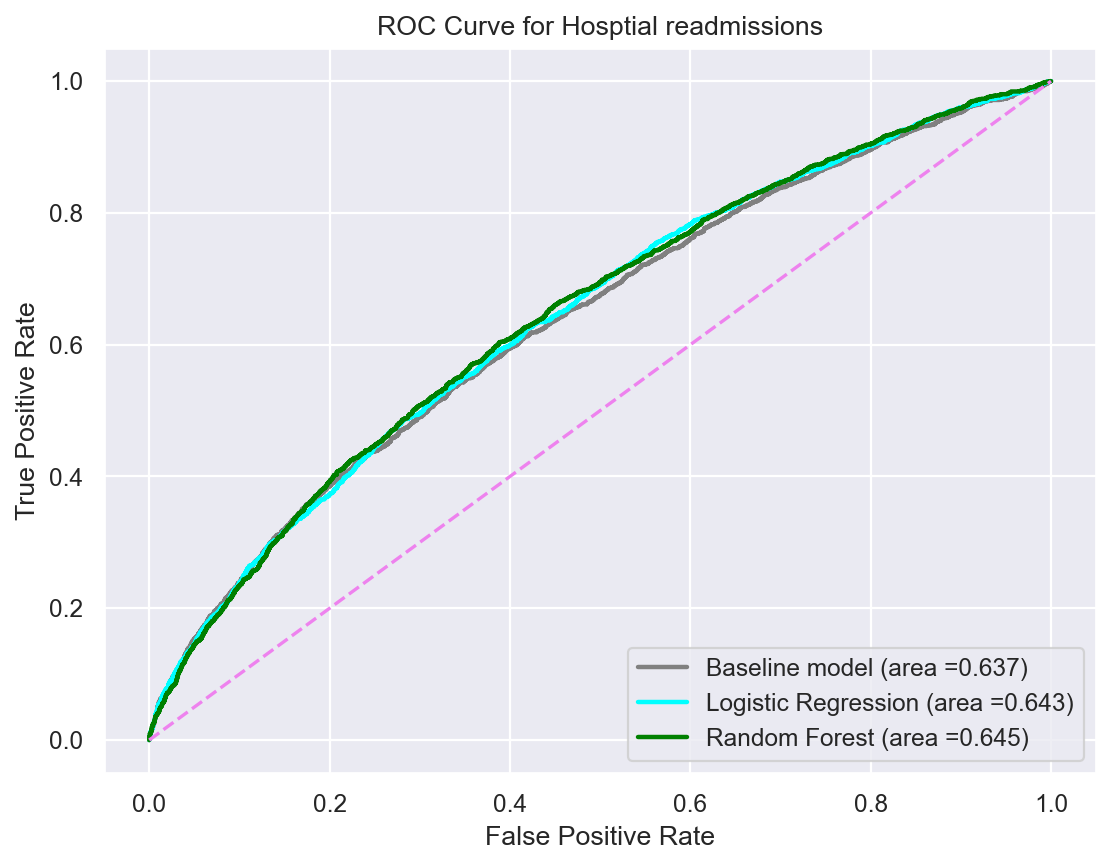

In [270]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr1_baseline, tpr1_baseline,lw=2, c= 'gray',label = "Baseline model (area ={:.3f})".format(roc_auc_score(y_test_numerical, lr_baseline.predict_proba(X_test_numerical)[:,1])))
plt.plot(fpr1_LR, tpr1_LR,lw=2, c='cyan',label = "Logistic Regression (area ={:.3f})".format(roc_auc_score(y_test, gridcv_lr_allFeatures.predict_proba(X_test_scaled)[:,1])))
plt.plot(fpr1_RF, tpr1_RF,lw=2, c='green',label = "Random Forest (area ={:.3f})".format(roc_auc_score(y_test, CV_rfc.predict_proba(X_test)[:,1])))

plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hosptial readmissions');
plt.legend(loc='lower right')
plt.savefig("ROC Curve.png")

# Feature importance

In [308]:
def plot_feature_importance_RF(feature_importances,features_model):
    plt.style.use('ggplot')
    figure(figsize=(16, 12), dpi=80)
    n_features = len(features_model)
    plt.barh(np.arange(n_features),feature_importances,color='#619CFF')
    plt.yticks(np.arange(n_features),features_model)
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    plt.savefig('features_importance.png',dpi= 500)

In [293]:
feature_importance_df = pd.DataFrame({'feature importance': CV_rfc.best_estimator_.feature_importances_,'Features': all_features}, columns = ['feature importance','Features'])

In [296]:
feature_importance_df = feature_importance_df.sort_values('feature importance',ascending=False).copy()

In [297]:
feature_importance_df

,feature importance,Features
65,2.662279e-01,number_inpatient
62,6.879355e-02,num_medications
60,6.857748e-02,num_lab_procedures
59,6.803372e-02,time_in_hospital
66,5.304171e-02,number_diagnoses
...,...,...
3,1.027280e-06,gender_Other
35,3.208546e-07,acetohexamide_Other
47,9.134648e-08,troglitazone_Other
55,5.224455e-21,metformin-rosiglitazone_Other


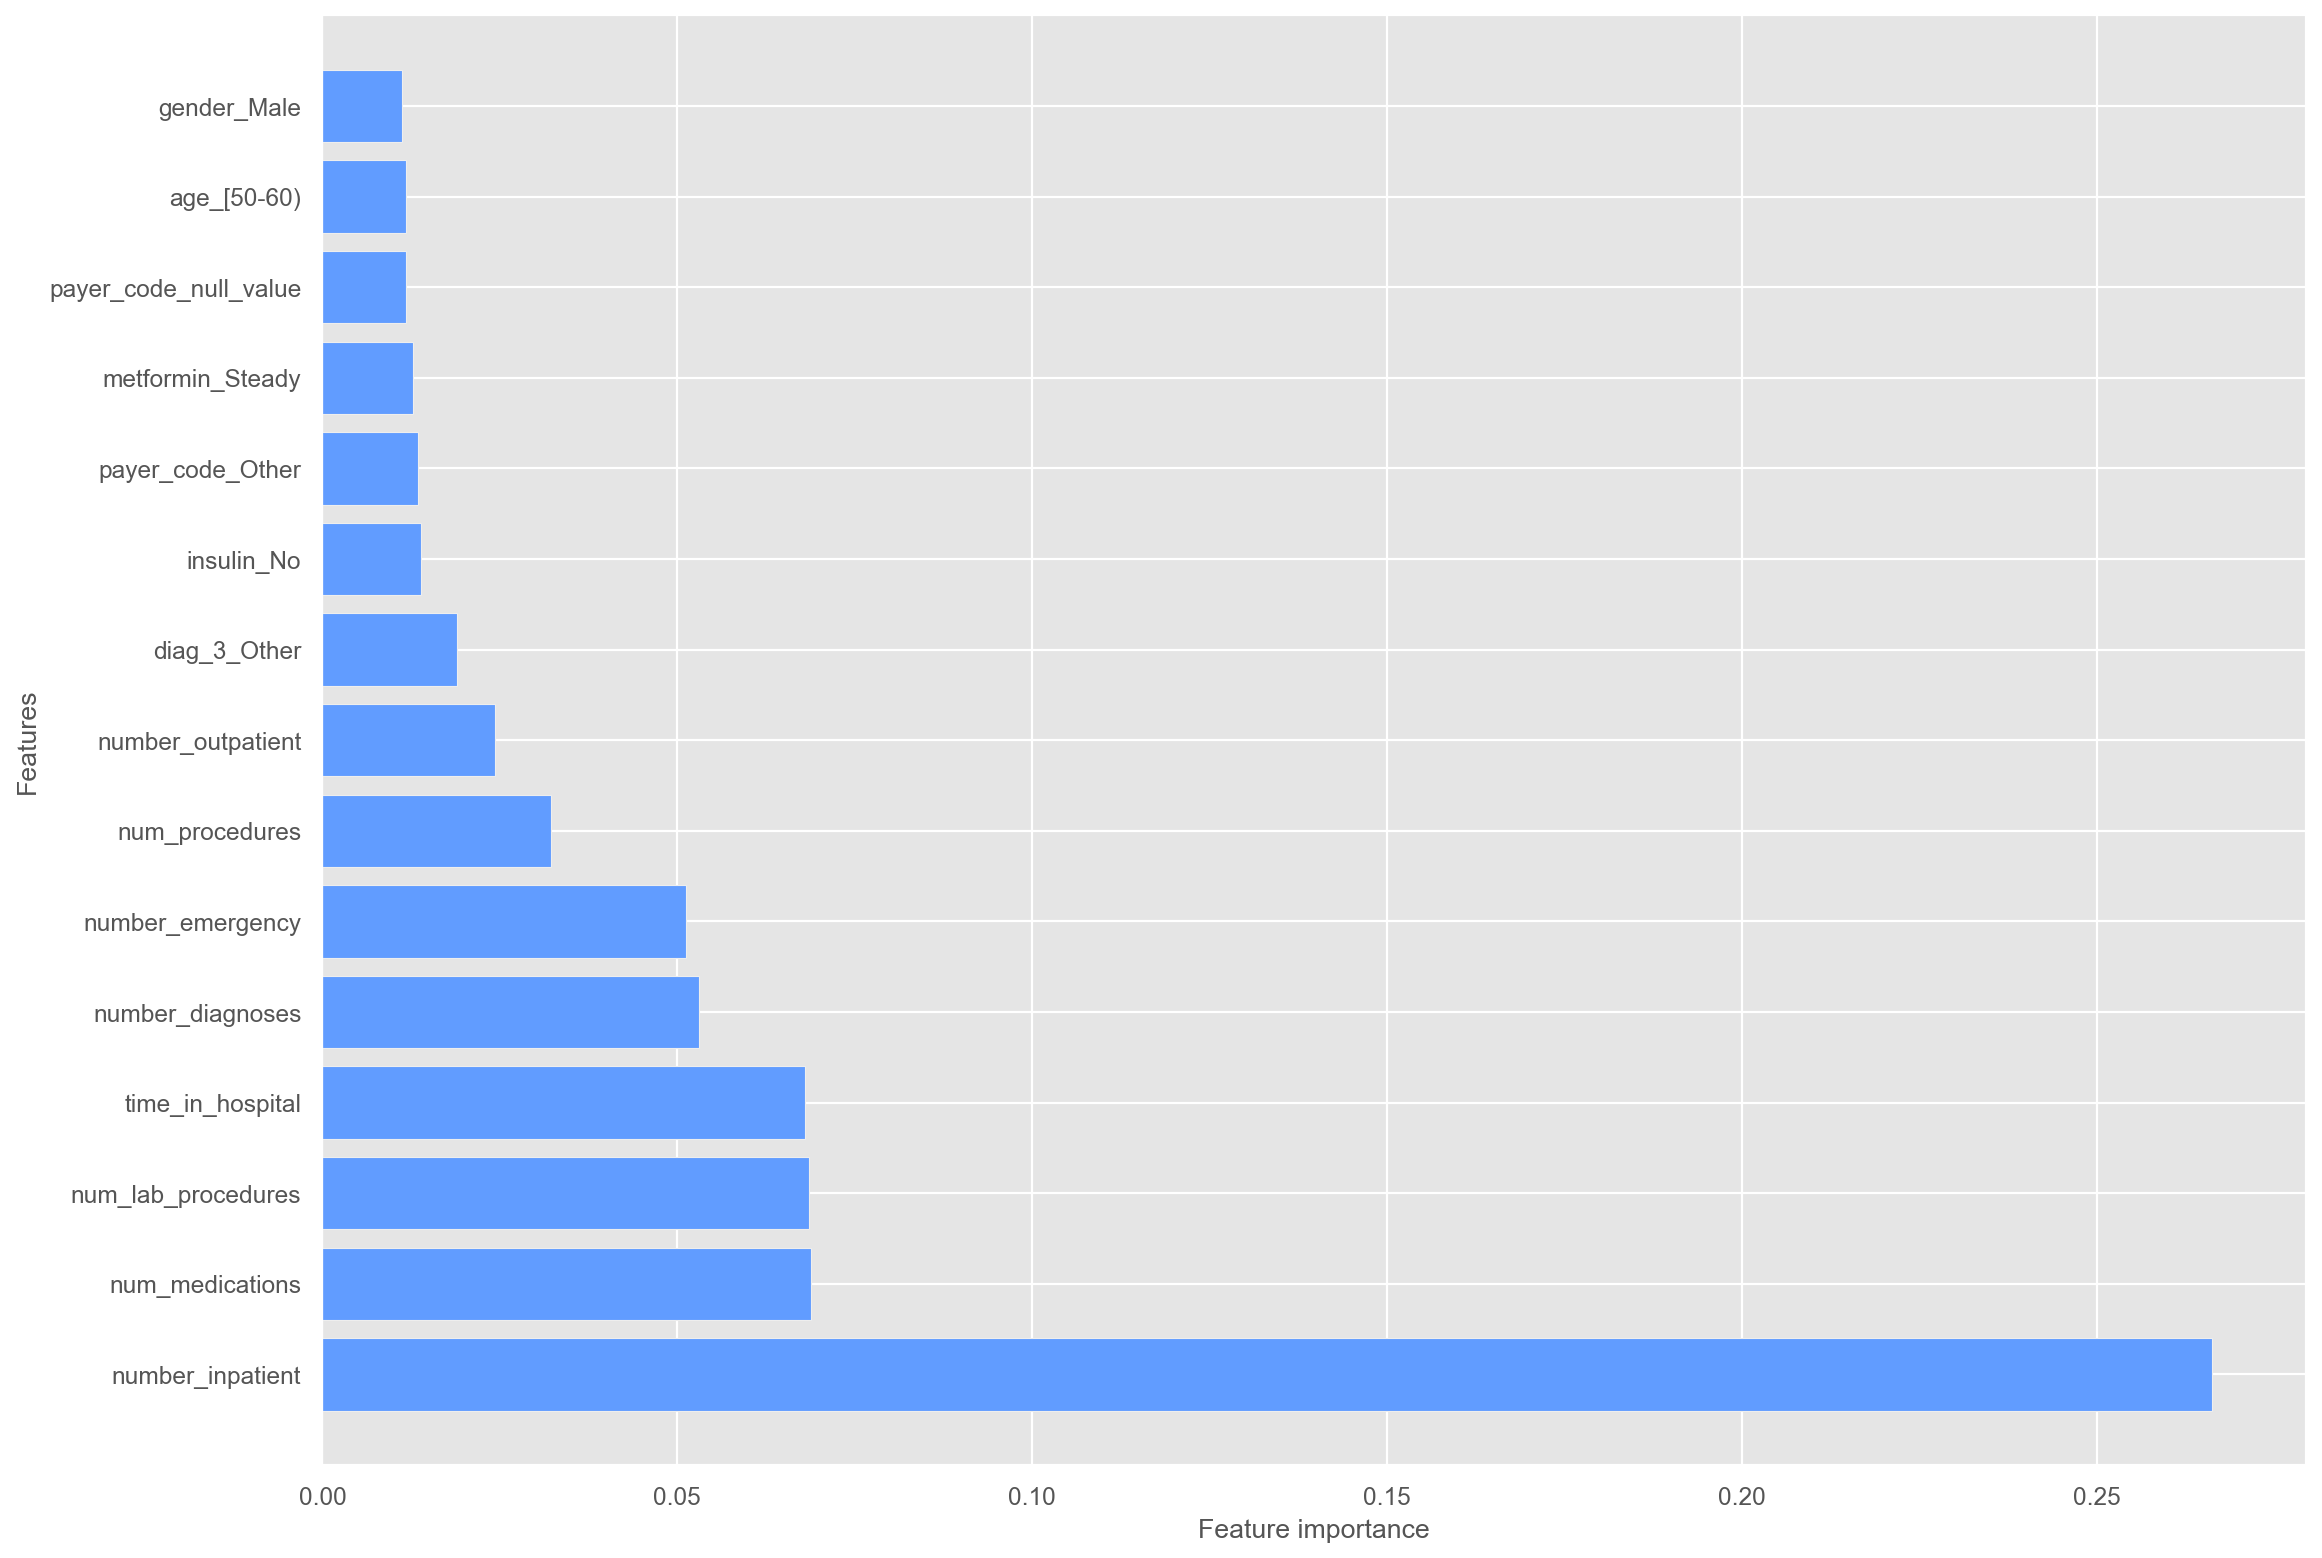

In [309]:
plot_feature_importance_RF(feature_importance_df['feature importance'][0:15],feature_importance_df['Features'][0:15])